In [1]:
from IPython.display import HTML
from IPython.display import Markdown

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> In order to make this notebook more readable I decided to enable the option of toggling on/off
cells with code. Click
<a href="javascript:code_toggle()">here</a> to test it.''')

#code snippet taken from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

### Replicating the notebook

In order to work in the same environment that the notebook was created in please use virtual environment. Steps are as follow:

1) Create a Python virtual environment by `$ python -m venv virtual_environment_name` (if you are using Python 2.7 or lower as the default OS Python please use `$ python3 -m venv virtual_environment_name`.

2) While in the project's directory `$ source virtual_environment_name/bin/activate`. Now all the lines in the terminal start with `(virtual_environment_name)`.

3) Install `jupyter` and/or `jupyterlab` by `$ pip install jupyter jupyterlab`.

4) While in the notebook run the cell below in order to install necessary libraries.

In [2]:
!pip install -r requirements.txt

fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.0 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In this Jupyter notebook I will try to explore the dataset containing programming languages code snippets. The task at hand is to <br><p style="text-align:center;font-weight: bold">classify programming languages based on the code.</p><br> Let's start with loading the *.csv* file.

## Data loading

The data is located in the same directory as the notebook that I'm currently using:

In [3]:
!ls | grep *.csv

data.csv


In order to read the data I will use *pandas* library:

In [4]:
import pandas as pd
pd.__version__

'0.23.4'

By inspecting the file in a spreadsheet application I know that the rows (observations) I'm interested in are preceded by a header row naming the variables I'll be using in my model.

In [5]:
data = pd.read_csv("data.csv")
data.head()

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...


In [6]:
Markdown(f"""The data provided has {data.shape[0]} rows and {data.shape[1]} columns.""")

The data provided has 16272 rows and 4 columns.

## Exploratory data analysis 
Having loaded the data, we can move to exploratory data analysis that will provide us with an insight into the data and give us ideas as to how proceed next.

### Missing data

The vital step of EDA is checking whether there are any missing values and if so, what is their nature. It turns out that there is at least one cell in the data that is `NaN`:

In [7]:
data.isnull().any().any()

True

The column `file_body` contains missing value(s):

In [8]:
data.isnull().any()

language     False
proj_id      False
file_id      False
file_body     True
dtype: bool

In [9]:
Markdown(f"""The count of missing values is {data.isnull().sum()['file_body']}.""")

The count of missing values is 4.

Let's retrieve the rows that has no value in `file_body`:

In [10]:
data[data.isnull().any(axis=1)]

,language,proj_id,file_id,file_body
1163,Swift,10518,101164,NaN
9951,Mathematica,15938,109952,NaN
12227,Julia,17632,112228,NaN
15290,Perl,19446,115291,NaN


In [11]:
data[data.isnull().any(axis=1)].index.values

array([ 1163,  9951, 12227, 15290])

In [12]:
Markdown(f"""Given that only {data.isnull().sum()['file_body']} out of  {data.shape[0]} rows are missing 
         we can delete the rows with `file_body` as `NaN`.""")

Given that only 4 out of  16272 rows are missing 
         we can delete the rows with `file_body` as `NaN`.

There's a trade-off between "not-hardcoding" and "having spaghetti code". What's the following one-liner does is:
<ol>
    <li>Get the data (row-wise) that is missing by: 
        <span style="background-color: #eff0f1">data[data.isnull().any(axis=1)]</span></li>
    <li>Retrieve indices of the rows that contain missing values by adding
        <span style="background-color: #eff0f1"> .index.values </span> to the former.</li>
    <li>As we have the row numbers we can filter the orignal data by calling 
        <span style="background-color: #eff0f1">data.index()</span> with those numbers.</li>
    <li>Finally we use 
        <span style="background-color: #eff0f1">data.drop() </span>, calling it with an argument 
            point 3 and save the new data to the already initialized  
        <span style="background-color: #eff0f1">data</span> variable.</li>
</ol>

In [13]:
data = data.drop(data.index[data[data.isnull().any(axis=1)].index.values])

### Insights & angles

How many languages are represented? Are there any that are over(/under)represented? What is the length of code chunks associated with those languages? In this section we answer these and similar questions.

These are the languages that we will be classifying:

In [14]:
data['language'].unique()

array(['JavaScript', 'Swift', 'Python', 'Java', 'C++', 'Ruby', 'Rust',
       'C', 'Scala', 'R', 'Go', 'Mathematica', 'Kotlin', 'Fortran',
       'Julia', 'PHP', 'MATLAB', 'Haskell', 'Perl'], dtype=object)

In [15]:
Markdown(f"""There are {len(data['language'].unique())} of them.""")

There are 19 of them.

Let's look at the distribution of documents written in a particular language:

In [16]:
dist_lang = data.groupby(['language'])['language'].count().sort_values(ascending=False)
dist_lang

language
Python         1452
Haskell        1333
Perl           1135
Ruby           1104
JavaScript     1104
C              1078
Go              998
Java            987
Mathematica     926
C++             880
Scala           802
Fortran         745
Kotlin          643
Julia           637
R               603
MATLAB          544
PHP             477
Rust            417
Swift           403
Name: language, dtype: int64

In [17]:
Markdown(f"""The top three are <b>{", ".join(dist_lang.index.values[:3])}</b> while the least popular
         in the file are <b>{", ".join(dist_lang.index.values[-3:])}</b>.""")

The top three are <b>Python, Haskell, Perl</b> while the least popular
         in the file are <b>PHP, Rust, Swift</b>.

For the visualisation purposes I'll be using `altair` library that is useful in a sense that it employs declarative approach (also used in R's ggplot2) which is in contrast to an imperative one used in `matplotlib`. 

In [18]:
import altair as alt
alt.__version__

'2.3.0'

In order to use `altair` with `pandas` we need to have a dataframe containing the count information. You can notice there is some redundancy in the `dist_lang_df` (index of the dataframe is virtually the same as the `"language"` column) but it's needed in order to correctly graph with `altair`:

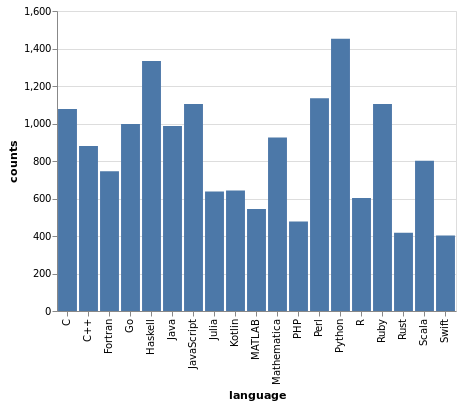

In [19]:
dist_lang_df = pd.DataFrame({"language": dist_lang.index.values,
                            "counts": dist_lang})

alt.Chart(dist_lang_df).mark_bar().encode(
    alt.X("language:N"),
    alt.Y("counts")
)

The bar charts present the count information based on the number of files containing a particular language's syntax. What is the count of file's associated with each project?

In [20]:
lang_project = data.groupby(['proj_id', 'language'])['file_body'].count().sort_values(ascending=False)

In [21]:
Markdown(f"""There are {len(lang_project)} distinct projects in total. Given the fact that we've
deleted files that had no entry in `file_body` column the smallest number-of-file-wise that a project 
can have is 1 and it is the case:""")

There are 10006 distinct projects in total. Given the fact that we've
deleted files that had no entry in `file_body` column the smallest number-of-file-wise that a project 
can have is 1 and it is the case:

In [22]:
lang_project.tail()

proj_id  language   
16104    Mathematica    1
16105    Mathematica    1
16106    Mathematica    1
16108    Mathematica    1
15004    R              1
Name: file_body, dtype: int64

The largest projects are as follows:

In [23]:
lang_project.head()

proj_id  language
17404    Fortran     41
19276    Haskell     19
10888    Python      15
18932    Haskell     14
11158    Python      14
Name: file_body, dtype: int64

Let's turn our attention to actual code snippets provided in the dataset. How are files of particular languages structured? The following dataframe lists one example of each language. Iterating the dataframe gives us:

In [24]:
tmp_df = data.loc[:, ["language", "file_body"]].drop_duplicates(subset=['language'])
for row_no in range(tmp_df.shape[0]):
    print('\033[1m' + tmp_df.iloc[row_no, :]["language"] +'\033[0m' + "\n")
    print(tmp_df.iloc[row_no, :]["file_body"])
    print("-----------------------------------------------------\n")

JavaScript

// Functions as values of a variable
var cube = x => Math.pow(x, 3);

var cuberoot = x => Math.pow(x, 1 / 3);


// Higher order function
var compose = (f, g) => (x => f(g(x)));

// Storing functions in a array
var fun = [ Math.sin, Math.cos, cube ];
var inv = [ Math.asin, Math.acos, cuberoot ];

for (var i = 0; i < 3; i++) {
  // Applying the composition to 0.5
  console.log(compose(inv[i], fun[i])(0.5));
}

-----------------------------------------------------

Swift

import Darwin
func compose<A,B,C>(f: (B) -> C, g: (A) -> B) -> (A) -> C {
  return { f(g($0)) }
}
let funclist = [ { (x: Double) in sin(x) }, { (x: Double) in cos(x) }, { (x: Double) in pow(x, 3) } ]
let funclisti = [ { (x: Double) in asin(x) }, { (x: Double) in acos(x) }, { (x: Double) in cbrt(x) } ]
println(map(zip(funclist, funclisti)) { f, inversef in compose(f, inversef)(0.5) })

-----------------------------------------------------

Python

>>> # Some built in functions and their inverses
>>> from math 

One insight that we've been given by the preceding code snippets is that their length differ, e.g R in comparison to Java, Mathematica to Fortran. As the relationship between code's lenghth and language might be misrepresented in the cell above let's condsider another variable `code_length`:

In [25]:
data["code_length"] = data["file_body"].apply(len)
data.head()

,language,proj_id,file_id,file_body,code_length
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...,411
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...,493
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...,400
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n",30
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...,1346


Let's look at basic statistics for each language `code_length`-wise, but first general information on the column. 

In [26]:
data["code_length"].describe()[1:]

mean      697.007438
std      1116.879086
min         2.000000
25%       129.000000
50%       346.000000
75%       831.000000
max     30106.000000
Name: code_length, dtype: float64

In [27]:
df_stats = data[["language", "code_length"]].groupby(["language"]).describe()
df_stats.applymap("{0:.2f}".format)

code_length                                                    \
                  count     mean      std    min     25%     50%      75%   
language                                                                    
C               1078.00  1037.25  1292.45   7.00  254.00  634.00  1303.25   
C++              880.00  1047.27  1367.43   7.00  244.00  550.00  1327.25   
Fortran          745.00  1281.32  2488.91   6.00  186.00  567.00  1407.00   
Go               998.00   992.99  1114.34   5.00  275.00  654.00  1299.50   
Haskell         1333.00   576.68   808.62   2.00  128.00  304.00   682.00   
Java             987.00  1082.33  1410.97  11.00  245.00  646.00  1369.50   
JavaScript      1104.00   689.79   963.89   2.00  119.75  331.50   878.00   
Julia            637.00   385.50   453.45   3.00   92.00  231.00   518.00   
Kotlin           643.00   917.93   819.14  30.00  351.50  721.00  1210.00   
MATLAB           544.00   420.91  1083.45   3.00   68.00  138.50   372.50   
Mathematica      926.00   235.98   368.59   2.00   51.00  121.00   271.75   
PHP              477.00   480.05   747.40   4.00   97.00  247.00   565.00   
Perl            1135.00   456.29   659.14   5.00  103.50  222.00   534.50   
Python          1452.00   636.97  1120.03   4.00  134.00  335.00   738.75   
R                603.00   332.94   408.57   6.00   64.50  184.00   438.00   
Ruby            1104.00   485.90   609.60  11.00  122.00  272.00   602.00   
Rust             417.00   799.97  1132.19  12.00  182.00  446.00   895.00   
Scala            802.00   638.34   863.54  12.00  159.00  356.00   784.00   
Swift            403.00   539.22   845.60  10.00  103.50  252.00   579.00   

                       
                  max  
language               
C            13700.00  
C++          10579.00  
Fortran      30106.00  
Go            9465.00  
Haskell       8358.00  
Java         15657.00  
JavaScript   13079.00  
Julia         4932.00  
Kotlin        5535.00  
MATLAB       15922.00  
Mathematica   5195.00  
PHP           7551.00  
Perl          8245.00  
Python       27789.00  
R             3005.00  
Ruby          5178.00  
Rust         10203.00  
Scala         9934.00  
Swift         7067.00

As the `count` column doesn't provide any information about the code snippets' structure, it will be dropped. A maze of numbers is not informative enough, so let's look at a heatmap that scales data column-wise. First step is to normalize within columns. There's also the case of the following peculiar column names:

In [28]:
list(df_stats)

[('code_length', 'count'),
 ('code_length', 'mean'),
 ('code_length', 'std'),
 ('code_length', 'min'),
 ('code_length', '25%'),
 ('code_length', '50%'),
 ('code_length', '75%'),
 ('code_length', 'max')]

That's way we need to get to the "inner" dataframe:

In [29]:
df_stats = df_stats.code_length
df_stats.head()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
C,1078.0,1037.247681,1292.446214,7.0,254.0,634.0,1303.25,13700.0
C++,880.0,1047.269318,1367.425722,7.0,244.0,550.0,1327.25,10579.0
Fortran,745.0,1281.324832,2488.910274,6.0,186.0,567.0,1407.00,30106.0
Go,998.0,992.986974,1114.339570,5.0,275.0,654.0,1299.50,9465.0
Haskell,1333.0,576.682671,808.615098,2.0,128.0,304.0,682.00,8358.0


In [30]:
def scaler_min_max(x):
    return (x-x.min()) / (x.max() - x.min())

df_stats = df_stats.drop(["count"], axis=1)
norm_df = df_stats.apply(scaler_min_max, axis=0)

norm_df

,mean,std,min,25%,50%,75%,max
language,,,,,,,
C,0.766510,0.435714,0.178571,0.675541,0.855000,0.908610,0.394635
C++,0.776097,0.471077,0.178571,0.642263,0.715000,0.929751,0.279473
Fortran,1.000000,1.000000,0.142857,0.449251,0.743333,1.000000,1.000000
Go,0.724169,0.351714,0.107143,0.745424,0.888333,0.905307,0.238368
Haskell,0.325923,0.207526,0.000000,0.256240,0.305000,0.361374,0.197520
Java,0.809632,0.491615,0.321429,0.645591,0.875000,0.966968,0.466846
JavaScript,0.434126,0.280760,0.000000,0.228785,0.350833,0.534023,0.371721
Julia,0.143034,0.040022,0.035714,0.136439,0.183333,0.216913,0.071104
Kotlin,0.652373,0.212491,1.000000,1.000000,1.000000,0.826470,0.093354


In [31]:
import seaborn as sns

sns.heatmap(norm_df)

To get even more insight we can produce boxplots - one for each language:

In [32]:
alt.data_transformers.enable('json') #disables maximum number of rows in altair

DataTransformerRegistry.enable('json')

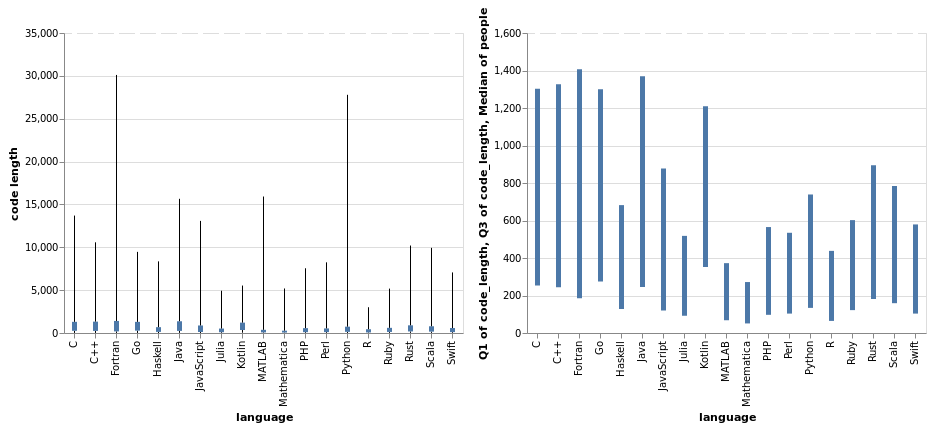

In [33]:
lower_box = 'q1(code_length):Q'
lower_whisker = 'min(code_length):Q'
upper_box = 'q3(code_length):Q'
upper_whisker = 'max(code_length):Q'

base = alt.Chart(data)
lower_plot = base.mark_rule().encode(
    y=alt.Y(lower_whisker, axis=alt.Axis(title="code length")),
    y2=lower_box,
    x="language:N"
)

middle_plot = base.mark_bar(size=5.0).encode(
    y=lower_box,
    y2=upper_box,
    x="language:N"
)

upper_plot = base.mark_rule().encode(
    y=upper_whisker,
    y2=upper_box,
    x="language:N"
)

middle_tick = base.mark_tick(
    color='white',
    size=5.0
).encode(
    y='median(people):Q',
    x="language:N"
)

custom = middle_plot + middle_tick
custom.configure_axisY(labels=False)
lower_plot + middle_plot + upper_plot + middle_tick | custom

Max value of `code_length` greatly distorts the boxplots. On the right, a version of boxplots that covers only points from the first to the third quartiles. By visually inspecting the custom boxplots we can't say that some particular languages' code snippets are short or long. Thus the only way to classify the languages is to use information in `file_body` column, i.e syntax.

## Training & testing sets

Before we move on to building a model, we need to partition the data into a training set and a test set. The former will be used, as the name indicates, for training purposes, finding the connection between a language's syntax and the `language` column. Having trained the model, its accuracy will be evaluated on unseen testing set.

As the EDA showed, distribution of languages is uneven. Our aim, while creating training and test sets, should be to keep them balanced. In other words, the differences between distribution among the two sets should come from random error, but not from systematic bias. By `y` we denote the dependent variable and by `x` the independent variable (if there were more than one variable we would rather opt fot `X` as in matrix notation).

In [34]:
x, y = data['file_body'], data['language']
print(x.head())
y.head()

0    // Functions as values of a variable\nvar cube...
1    // Functions as values of a variable\nvar cube...
2    function median(ary) {\n    if (ary.length == ...
3                 [\n  null,\n  4,\n  3.5,\n  2.1\n]\n
4    (() => {\n    'use strict';\n\n    // median :...
Name: file_body, dtype: object


0    JavaScript
1    JavaScript
2    JavaScript
3    JavaScript
4    JavaScript
Name: language, dtype: object

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=0) #70% for training set, 30% for test set

The following cell shows the distribution of languages in each set. These are rather similar:

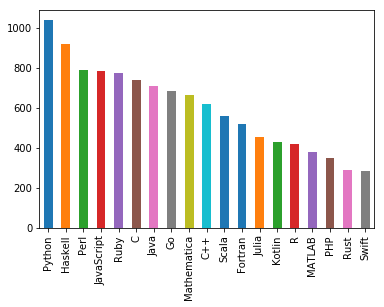

In [36]:
y_train.value_counts().plot(kind="bar")

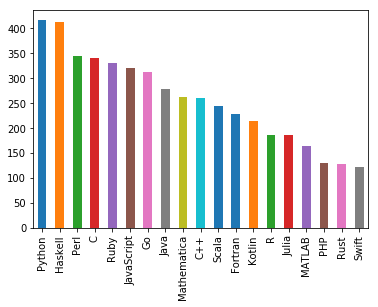

In [37]:
y_test.value_counts().plot(kind="bar")

## Model

### N-grams

In [38]:
ex_code = data["file_body"][12000]

Natural Language Processing uses text-preprocessing technique known as n-grams. The idea is to divide the text into tuples (each of length n). Consider an example:

In [39]:
sentence = "An example."

In [40]:
from nltk import ngrams
list(ngrams(sentence, 5))

[('A', 'n', ' ', 'e', 'x'),
 ('n', ' ', 'e', 'x', 'a'),
 (' ', 'e', 'x', 'a', 'm'),
 ('e', 'x', 'a', 'm', 'p'),
 ('x', 'a', 'm', 'p', 'l'),
 ('a', 'm', 'p', 'l', 'e'),
 ('m', 'p', 'l', 'e', '.')]

### Keywords

[This](https://github.com/e3b0c442/keywords) webpage presents lists of keywords for most of the languages we consider. I will be using `BeautifulSoup` library in order to scrape the appropriate content:

In [41]:
from urllib.request import urlopen #open URLs
from bs4 import BeautifulSoup #extract data from HTML

url = "https://github.com/e3b0c442/keywords"
html = urlopen(url)

In [42]:
soup = BeautifulSoup(html, 'html.parser')
type(soup)

bs4.BeautifulSoup

Keywords are stored in tables. Each of the `<table></table>` is directly the next element (on the same indentation level) to `<h3></h3>`. If an anchor (`<a></a>`) is a direct child of a header then the table must contain keywords:

In [43]:
import re
prog_langs = dict()
all_h3 = soup.find_all("h3")
for h3 in all_h3:
    a_child = h3.findChild("a")
    if a_child: #proceed if there is a child 
        keywords = []
        #e.g. there are two versions of C and keys in dict must be unique --> use tuple as key in dict
        lang = tuple(h3.get_text().split()[:2])
        table = h3.findNext("tbody") #ignore table because it's the parent of tbody
        content = table.find_all("td") #cells' content stored in <td></td>
        for word in content:
            text = word.get_text() #'<td>text</td>'.get_text() 
            if text: #empty cells are represented by ''
                keywords.append(text)
        prog_langs[lang] = keywords

for key in prog_langs:
    print(key)

('C', '(ANSI)')
('C', '(C18)')
('C#', '(5.0)')
('C++', '(C++17)')
('Dart', '(1)')
('Elixir', '(1.7)')
('Erlang', '(21.2)')
('Go', '(1.11)')
('JS', '(ES2018)')
('Java', '(SE')
('Kotlin', '(1.3)')
('PHP', '(7.0)')
('Python', '(2.7)')
('Python', '(3.7)')
('R', '(3.5)')
('Ruby', '(2.5)')
('Rust', '(1.31)')
('Scala', '(2.12)')
('Swift', '(4.2)')


We don't need all the languages that we listed on the webpage. We choose C18 over C ANSI because the former contains more words thant the latter.

In [44]:
langs = ["C", "C++", "Go", "Java", "JS", "Kotlin", "PHP", "Python", "R", "Ruby", "Rust", "Scala", "Swift"]

In [45]:
keys_to_keep = []
for key in prog_langs.keys():
    if key == ('C', '(ANSI)') or key == ('Python', '(2.7)'):
        next
    elif key[0] in langs:
        keys_to_keep.append(key)

for key in list(prog_langs.keys()): #prog.langs().keys() produces iterator --> removing an item from iterator results in RunTimeError --> make a list
    if key not in keys_to_keep:
        del prog_langs[key]

prog_langs.keys()

dict_keys([('C', '(C18)'), ('C++', '(C++17)'), ('Go', '(1.11)'), ('JS', '(ES2018)'), ('Java', '(SE'), ('Kotlin', '(1.3)'), ('PHP', '(7.0)'), ('Python', '(3.7)'), ('R', '(3.5)'), ('Ruby', '(2.5)'), ('Rust', '(1.31)'), ('Scala', '(2.12)'), ('Swift', '(4.2)')])

In [46]:
#update keys
for key in list(prog_langs.keys()): #avoiding RunTimeError by using list() on keys
    prog_langs[key[0]] = prog_langs.pop(key)

In [47]:
#update JS to JavaScript (as in the data)
prog_langs["Javascript"] = prog_langs.pop("JS")
prog_langs.keys()

dict_keys(['C', 'C++', 'Go', 'Java', 'Kotlin', 'PHP', 'Python', 'R', 'Ruby', 'Rust', 'Scala', 'Swift', 'Javascript'])

There are few languages that are missing. The dictionary will be updated based on various web sources.

#### Fortran

In [48]:
url = "http://fortranwiki.org/fortran/show/Keywords"
html = urlopen(url)

In [49]:
soup = BeautifulSoup(html, 'html.parser')
type(soup)

bs4.BeautifulSoup

In [50]:
soup.find("h2", {"id": "fortran_77"})

<h2 id="fortran_77">FORTRAN 77</h2>

We find all `<h2></h2>` headers. We check whether a header has a paragraph underneath. If so, we add text from the paragraph to the list:

In [51]:
headers = ['h2']
fortran_raw = []
for header in soup.findAll(headers): #find all h2 headers in the HTML code
    for elem in header.next_siblings:
        if elem.name == "p" and len(elem.get_text()) > 0:
            fortran_raw.append(elem.get_text())

The first paragraph need some additional processing:

In [52]:
record = fortran_raw[0]
record

'The following keywords were defined in FORTRAN 77: assign, backspace, block data, call, close, common, continue, data, dimension, do, else, else if, end, endfile, endif, entry, equivalence, external, format, function, goto, if, implicit, inquire, intrinsic, open, parameter, pause, print, program, read, return, rewind, rewrite, save, stop, subroutine, then, write.'

In [53]:
fortran_raw = fortran_raw[:5] #only the first 5 paragraphs are of interst

The `#1` line can be represented as a list of actions:

1) `record[record.find(":")+1:]` deletes excerpts such as: *"The following keywords were defined in FORTRAN 77:"*

2) We split the string into list by comas in `split(",")` step.

3) `x.strip()` strips words from whitespaces.


In `#2` we delete full stops from last words.

In `#3` we use `extend()` because we want to merge two lists but not by inserting a list at the end  of another list.

In [54]:
import string
fortran_keywords = []
for record in fortran_raw:
    tmp = [x.strip() for x in record[record.find(":")+1:].split(",")] #1
    last = tmp.pop() #delete and return the last element of a list
    last = last[:last.find(".")] #2
    tmp.append(last)
    fortran_keywords.extend(tmp) #3

In [55]:
# add Fortran keywords to the dictionary
prog_langs["Fortran"] = fortran_keywords

#### Haskell

In [56]:
haskell_keywords = \
  ["case","class","data","default","deriving","do","else","forall"
  ,"if","import","in","infix","infixl","infixr","instance","let","module"
  ,"newtype","of","qualified","then","type","where","_"
  ,"foreign","ccall","as","safe","unsafe"]
keyglyphs = \
  ["..","::","=","\\","|","<-","->","@","~","=>","[","]"]
symbols = \
  "!#$%&*+./<=>?@\\^|-~"

In [57]:
prog_langs["Haskell"] = haskell_keywords

#### Julia

In [58]:
keywords_sm = ["begin","while","if","for","try","return","break","continue","function","macro",
            "quote","let","local","global","const","do","struct","module","baremodule",
            "using","import","export"]

In [59]:
url = "https://discourse.julialang.org/t/julia-reserved-key-words/4781"
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [60]:
julia_keywords = soup.find("code").get_text().split()

In [61]:
prog_langs["Julia"] = julia_keywords

#### MATLAB

The scraped words are in form `"'word'"` and we want them to be `"word"`. In order to achieve this we use a regular expression that filters out non-alphabet characters:

In [62]:
url = "https://www.mathworks.com/help/matlab/ref/iskeyword.html"
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [63]:
import re

raw_ticks = soup.find_all("pre", {"class": "programlisting"})[1].get_text().split()
print(raw_ticks)

regex = re.compile('[^a-zA-Z]')
MATLAB_keywords = [regex.sub("", raw_word) for raw_word in raw_ticks]
MATLAB_keywords = MATLAB_keywords[1:] #the first entry is iskeyword() function

['iskeyword', "'break'", "'case'", "'catch'", "'classdef'", "'continue'", "'else'", "'elseif'", "'end'", "'for'", "'function'", "'global'", "'if'", "'otherwise'", "'parfor'", "'persistent'", "'return'", "'spmd'", "'switch'", "'try'", "'while'"]


In [64]:
prog_langs['MATLAB'] = MATLAB_keywords

#### Mathematica

In [65]:
prog_langs["Mathematica"] = [] #couldn't find keywords

#### PERL

In [66]:
url = "https://learn.perl.org/docs/keywords.html"
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [67]:
tds = soup.find_all("td")
Perl_keywords = [td.get_text() for td in tds if len(td.get_text()) > 0]

In [68]:
prog_langs["Perl"] = Perl_keywords

In [69]:
len(list(prog_langs.keys())) #sanity check (must be equal number of languages in EDA)

19

In order to make replicating this analysis easier I decided to store keywords dictionary in an external file that can be loaded if structure of any of the scraped websites is altered. The `dict.json` file will be stored in the project's directory:

In [70]:
import json

with open("dict.json", 'w') as fp:
    json.dump(prog_langs, fp, sort_keys=True, indent=4)

The file can be loaded as follows:

In [71]:
# with open('dict.json', 'r') as fp:
#     test = json.load(fp)

This approach is based on Bayes theorem:

$$ P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)} $$

where $P(A \mid B)$ is a conditional probability that A happens given that B is true. $P(B \mid A)$ denotes B happening if A is true. $P(A)$ and $P(B)$ are probabilities that A and B will happen, respectively.

The intuition behind Bayes theorem is to, before we begin any experiment, to decide on the value of prior probability (our intuition) - $P(A) $ - and then, as the data comes in, to update the posterior probability (our intuition updated with data) - $P(A \mid B)$. 

The input to the algorithm must be a matrix which consists of words' count data or frequency. Let's start with counting words. The immediate problem that we stumble upon is the fact that code snippet's syntax is not an example of natural language but a synthethic array of words. A strategy to separate 'words' must be devised.

The intuitive way in which to proceed when analyzing natural language is to lemmatize and tokenize the text, delete punctuation and stopwords. In case of programming syntax we should focus on keeping keywords of programming languages e.g. `import`, `from` in Python, `println` in Java or `include` in C++. All other information such as names of variables, numbers, escape sequences should be deleted in the preprocessing stage. One aspect of preprocessing deserves special attention. Should we delete `\t` that is indicative of scripting languages such as Ruby or Python? I would argue yes, because all other languages (even if it's not required by the compiler) are written with some kind of indendation standard. 

A separate paragraph should be dedicated to comments. At first sight it seems logical to delete them as they do not pertain to programming language syntax. However, comments are indicated differently in differently languages. Let's take Python and C++ for instance: `#` in Python indicates a one line comment and in C++ it precedes a keyword `include`. While looking at a code snippet of yet unknown language the algorithm won't be able to correctly delete the comment. This is why comments stay - I hope that comment/code ratio is low enough so that comments do not distort the keywords as proxy for programming language.

The following regex will help us to extract appropriate content from code snippets. As it is an adhoc solution results are not perfect:

In [72]:
x_train_list = x_train.tolist() #list of training set code snippets
text = x_train_list[1210]
print(text)

import re
pattern = re.compile(r'[^a-zA-Z#++.-_]')

clean_text = re.sub(pattern, " ", text)
print(clean_text)

// version 1.1.2

import java.awt.MouseInfo

fun main(args: Array<String>) {
    (1..5).forEach {
        Thread.sleep(1000)
        val p = MouseInfo.getPointerInfo().location  // gets screen coordinates
        println("${it}: x = ${"%-4d".format(p.x)} y = ${"%-4d".format(p.y)}")
    }
}

// version 1.1.2  import java.awt.MouseInfo  fun main args: Array<String>         1..5 .forEach           Thread.sleep 1000          val p = MouseInfo.getPointerInfo  .location  // gets screen coordinates         println    it : x =      4d .format p.x   y =      4d .format p.y             


In [73]:
y = y_train.tolist() #labels
y[:5]

['Haskell', 'Haskell', 'MATLAB', 'Kotlin', 'Python']

Let's creata a matrix that in rows stores the indices of training set examples and in columns features, i.e. extracted words:

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_vect = TfidfVectorizer(input="content", #sequnce string instead of files or filenames
                             stop_words = {'english'}, #delete English stopwords
                             lowercase=False, #"Data" and "data" two different words
                             analyzer ='word' #features made out of words
                            )

In [75]:
X_train_counts = count_vect.fit_transform(x_train_list)

In [76]:
X_train_counts.shape

(11387, 47191)

We get frequency of all features, e.g.:

In [77]:
ls_dict = list(count_vect.vocabulary_)
(ls_dict[0], count_vect.vocabulary_[ls_dict[0]])

('import', 29140)

Now we transform a count matrix to a term-frequency times inverse document-frequency form. The rationale behind this step is to make frequent words that occur throughout training set (corpus) less important and in turn to prioritize those that occur frequently but only in small fraction of groups.

In [78]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11387, 47191)

#### Model creation

We use multinomial Naive Bayes which description can be found [here](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

In [79]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y)

Test set transformation to TFIDF. We don't create a new `TfidfVectorizer` object because the `count_vect` has been already transformed in such a way it contains training data (note that we're using `transform` method):

In [80]:
X_new_counts = count_vect.transform(x_test.tolist()) #count data for test set
X_new_tfidf = tfidf_transformer.transform(X_new_counts) #tfidf for test set

predicted = clf.predict(X_new_tfidf) #list of predictions

### Confusion matrix

Let's check if the model classified test set instances well enough. Firstly, a look at metrics:

In [81]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [82]:
print(precision_recall_fscore_support(y_test, predicted, average="weighted"))

(0.8288922203716531, 0.719319811514034, 0.7122733768200556, None)


In [83]:
print(f1_score(y_test, predicted, average="weighted"))

0.7122733768200556


In [84]:
print(accuracy_score(y_test, predicted))

0.719319811514034


In [85]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted, labels=data['language'].unique())

In [86]:
# taken from https://github.com/Kamel773/SourceCodeClassification/blob/master/confusionMatrix.py

import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix2(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    sns.set(font_scale=1.1)
    sns.set_style("dark")
    sns.set_style("white",{"xtick.major.size": 10})
    plt.figure(figsize=(14,14))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,weight='bold').set_fontsize('22')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.05,left=0.15)
    plt.ylabel('True label',weight='bold').set_fontsize('16')
    plt.xlabel('Predicted Label',weight='bold').set_fontsize('16')
    plt.xticks(weight='bold',size=16)
    plt.yticks(weight='bold',size=16)
    #plt.ylabel(r'\textbf{Y-AXIS}', fontsize=20)
    #plt.xlabel(r'\textbf{X-AXIS}', fontsize=20)
    #plt.savefig("ConfusionMatrixAlgorithmia21.png", dpi=300)

Confusion matrix, without normalization


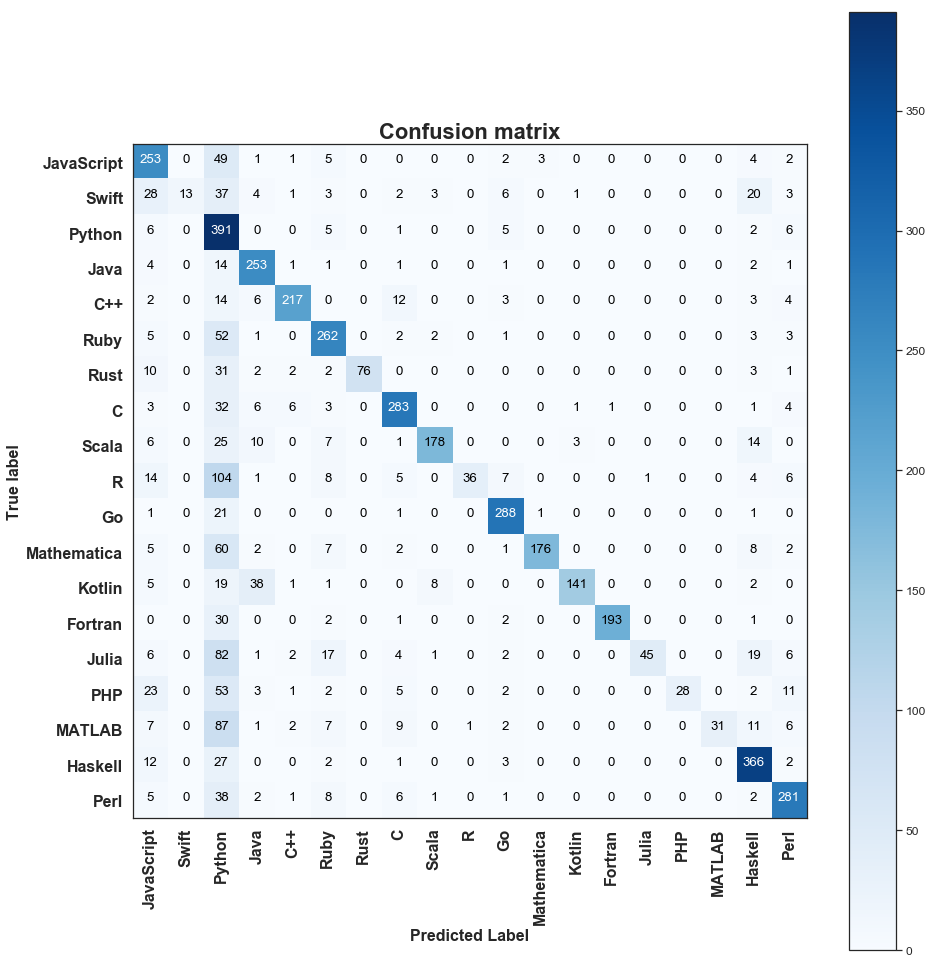

In [87]:
plot_confusion_matrix2(cm, classes=data["language"].unique())

Multinomial Naive Bayes operates based on alpha parameter, which we can optimize for. There is `class_prior` argument which by default uses prior probabilities based on training set. `fit_prior` set to `True` ensures that the model learns prior probabilities from data. We could use cross-validation in order to choose the optimal value of alpha parameter:

In [88]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [89]:
import numpy as np
np.arange(0, 1.01, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [90]:
param_grid = [
    {"alpha": np.arange(10e-1, 1.01, 0.2)}
]

In [91]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_tfidf, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.])}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [92]:
#sorted(grid_search.cv_results_.keys())
grid_search.cv_results_['params']

[{'alpha': 1.0}]

### Problems & next steps

1) Try Complement Naive Bayes ([implementation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB)).

2) Craft a more accurate regex used to separate keywords from noise. Ideally, we would be able to use scraped keywords.

3) Use a LSTM model.

4) Use n-grams.

5) Read papers that consider a similar problem as ours.

6) Solve misbalanced data problem - languages are misclassfied as Python (the most frequent language in the dataset).

7) Find Mathematica keywords.